In [15]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(directory)


In [13]:
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)

a
a
a
a
a
a
a
a
a
a
a


In [19]:
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, 1024, 256):
            for j in range(0, 1024, 256):
                sub_img = image[i:i+256, j:j+256]
                splitted.append(sub_img)
    return splitted

In [20]:
training_images = images

#normalise the probability maps
pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_probability_maps]
#binarise the cell masks
cm_binary = [np.where(image > 0, 1.0, 0.0) for image in training_cell_masks]

#pad the images, probability maps and cell masks to 1024x1024
images_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in training_images]
pm_norm_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in pm_normalised]
cm_bin_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cm_binary]

#split the images, probability maps and cell masks into 256x256 images
images_pad_split = split_image_set(images_pad)
pm_norm_pad_split = split_image_set(pm_norm_pad)
cm_bin_pad_split = split_image_set(cm_bin_pad)

#augment with rotations
images_rotated = []
pm_rotated = []
cm_rotated = []
for i in range(len(images_pad_split)):
    for j in range(1,4):
        images_rotated.append(np.rot90(images_pad_split[i],j))
        pm_rotated.append(np.rot90(pm_norm_pad_split[i],j))
        cm_rotated.append(np.rot90(cm_bin_pad_split[i],j))

#remove the images from cm_bin_pad_split that only have 0s, and remove them from images_pad_split and pm_norm_pad_split
images_pad_split_filtered = [images_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
pm_norm_pad_split_filtered = [pm_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
cm_bin_pad_split_filtered = [img for img in cm_rotated if np.sum(img) > 0]

print(len(images_pad_split_filtered), len(pm_norm_pad_split_filtered), len(cm_bin_pad_split_filtered))

468 468 468


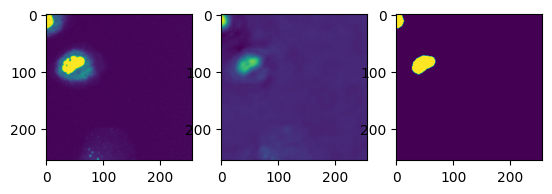

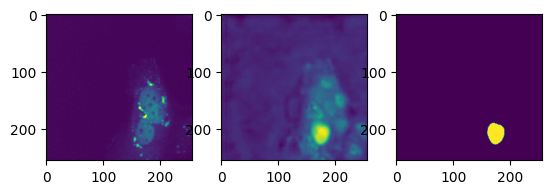

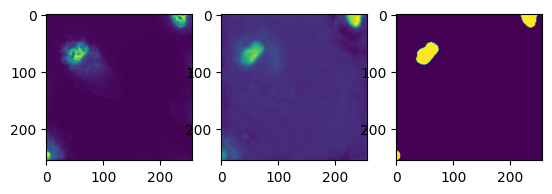

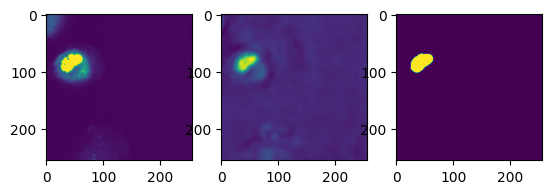

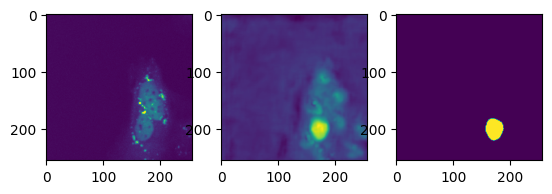

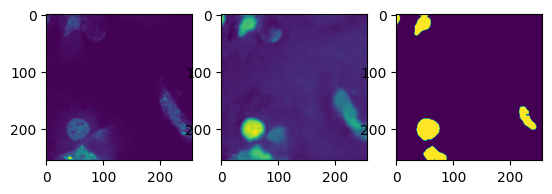

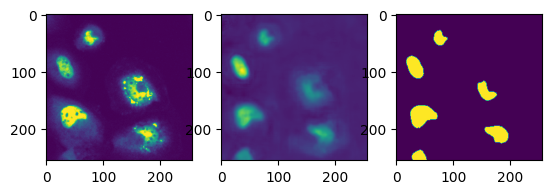

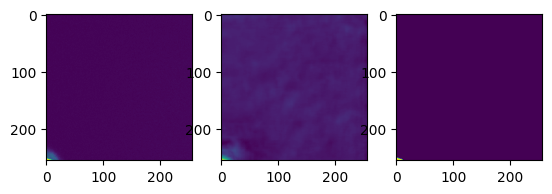

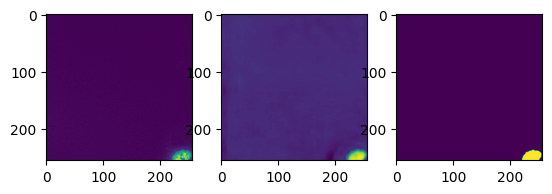

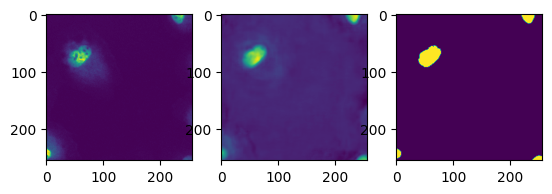

In [30]:
import matplotlib.pyplot as plt
import random

for j in range(10):
    i = random.randint(0, len(images_pad_split_filtered))

    plt.subplot(1,3,1)
    image = images_pad_split_filtered[i]
    #normalise the image
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.imshow(pm_norm_pad_split_filtered[i])

    plt.subplot(1,3,3)
    plt.imshow(cm_bin_pad_split_filtered[i])

    plt.show()

In [26]:
print(cm_bin_pad_split_filtered[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
